In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import kmapper as km
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.stats import iqr
import networkx as nx


In [15]:
df_departures = pd.read_pickle("../../calculated_distances_dep.pkl")

df_arrivals = pd.read_pickle("../../calculated_distances_arr.pkl")

print("Columns all:")
print(df_departures.columns.tolist())

Columns all:
['airportCode', 'date', 'deviation', 'delay']


In [16]:
# Filter month june, july and august

df_departures = df_departures[df_departures['date'].dt.month.isin([6, 7, 8])]

df_arrivals = df_arrivals[df_arrivals['date'].dt.month.isin([6, 7, 8])]

In [17]:
def fortnight_label(date):
    return f"{date.year}-{date.month:02d}-1" if date.day <= 15 else f"{date.year}-{date.month:02d}-2"

df_departures['half_month'] = df_departures['date'].apply(fortnight_label)

df_dep_by_airport = df_departures.groupby(['airportCode', 'half_month']).agg({
    'deviation': ['mean', 'median', 'std', iqr],
    'delay': ['mean', 'median', 'std', iqr]
}).reset_index()

df_dep_by_airport.columns = ['airportCode', 'half_month',
                                       'deviation_mean', 'deviation_median', 'deviation_std', 'deviation_iqr',
                                       'delay_mean', 'delay_median', 'delay_std', 'delay_iqr']

df_arrivals['half_month'] = df_arrivals['date'].apply(fortnight_label)

df_arr_by_airport = df_arrivals.groupby(['airportCode', 'half_month']).agg({
    'deviation': ['mean', 'median', 'std', iqr],
    'delay': ['mean', 'median', 'std', iqr]
}).reset_index()

df_arr_by_airport.columns = ['airportCode', 'half_month',
                                       'deviation_mean', 'deviation_median', 'deviation_std', 'deviation_iqr',
                                       'delay_mean', 'delay_median', 'delay_std', 'delay_iqr']



df_all_by_airport = pd.merge(df_dep_by_airport, df_arr_by_airport, on=['airportCode', 'half_month'], suffixes=('_dep', '_arr'))



print(df_all_by_airport.head())

print(df_all_by_airport.shape)

  airportCode half_month  deviation_mean_dep  deviation_median_dep  \
0        GCFV  2018-06-1         2304.763739           1329.510685   
1        GCFV  2018-06-2         2391.787929           1365.504177   
2        GCFV  2018-07-1         2411.844884           1377.410314   
3        GCFV  2018-07-2         2406.297568           1383.327200   
4        GCFV  2018-08-1         2253.239750           1339.341468   

   deviation_std_dep  deviation_iqr_dep  delay_mean_dep  delay_median_dep  \
0        2565.404128        2272.108072       -2.266650         -1.250000   
1        2755.568588        2468.878855       -2.097621         -1.708333   
2        2601.135309        2643.702294       -2.187654         -1.616667   
3        2746.605106        2447.044316       -2.166835         -1.733333   
4        2379.931378        2359.901361       -2.016262         -1.500000   

   delay_std_dep  delay_iqr_dep  deviation_mean_arr  deviation_median_arr  \
0       7.178255       9.091667        

In [18]:
df_dep_by_airport.fillna({'deviation_std': 0.0, 'delay_std': 0.0}, inplace=True)
print(df_dep_by_airport.isna().sum())

print()
df_arr_by_airport.fillna({'deviation_std': 0.0, 'delay_std': 0.0}, inplace=True)
print(df_arr_by_airport.isna().sum())


print()
df_all_by_airport.fillna({'deviation_std_dep': 0.0, 'delay_std_dep': 0.0, 'deviation_std_arr': 0.0, 'delay_std_arr': 0.0}, inplace=True)
print(df_all_by_airport.isna().sum())

airportCode         0
half_month          0
deviation_mean      0
deviation_median    0
deviation_std       0
deviation_iqr       0
delay_mean          0
delay_median        0
delay_std           0
delay_iqr           0
dtype: int64

airportCode         0
half_month          0
deviation_mean      0
deviation_median    0
deviation_std       0
deviation_iqr       0
delay_mean          0
delay_median        0
delay_std           0
delay_iqr           0
dtype: int64

airportCode             0
half_month              0
deviation_mean_dep      0
deviation_median_dep    0
deviation_std_dep       0
deviation_iqr_dep       0
delay_mean_dep          0
delay_median_dep        0
delay_std_dep           0
delay_iqr_dep           0
deviation_mean_arr      0
deviation_median_arr    0
deviation_std_arr       0
deviation_iqr_arr       0
delay_mean_arr          0
delay_median_arr        0
delay_std_arr           0
delay_iqr_arr           0
dtype: int64


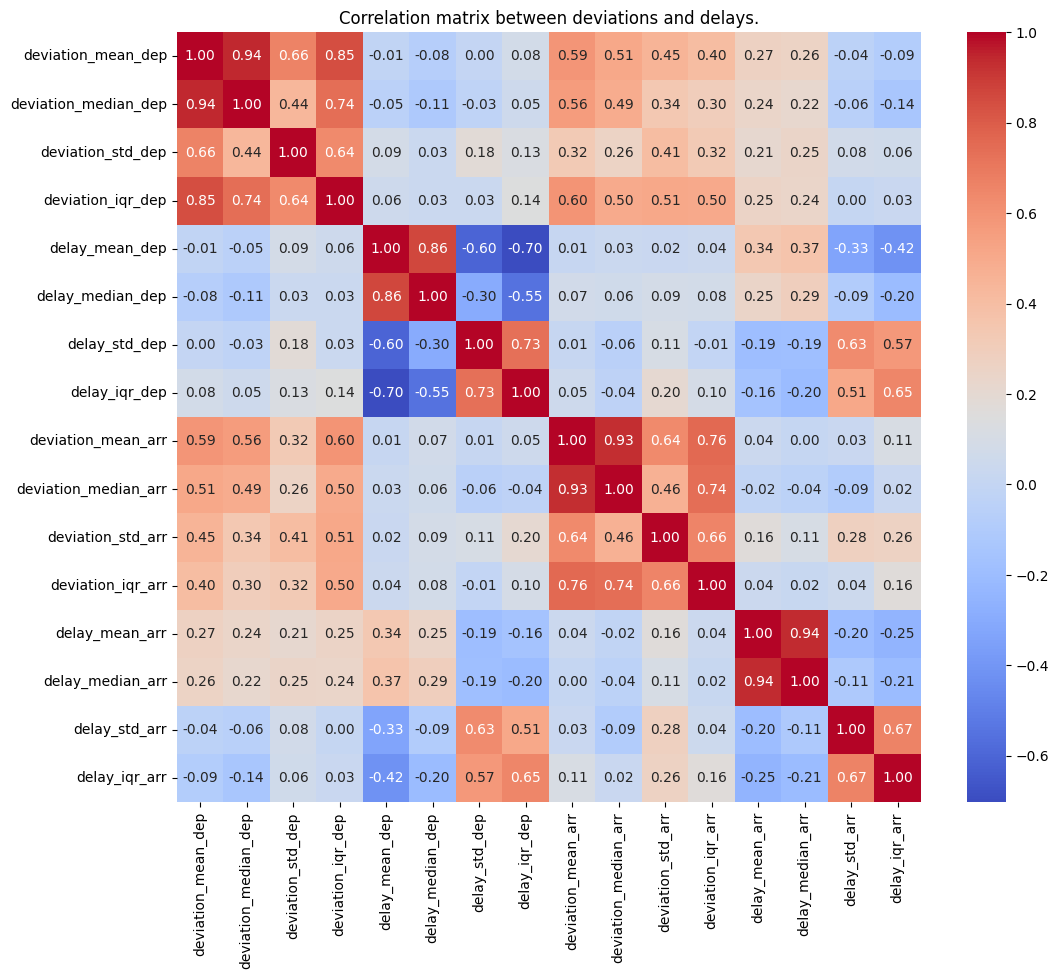

In [19]:
df_numeric = df_all_by_airport.drop(columns=['airportCode', 'half_month'])

corr_matrix = df_numeric.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix between deviations and delays.")
plt.show()

In [20]:
X_dep = df_dep_by_airport.drop(columns=['airportCode', 'half_month']).dropna()

print(X_dep.head())
print()

scaler = StandardScaler()
X_scaled_dep = scaler.fit_transform(X_dep)

df_spanish_airports = pd.read_pickle('../../spanish_airports.pkl')

custom_tooltips_dep = np.array([
    f"{row['half_month']} – {df_spanish_airports.loc[df_spanish_airports['ICAO'] == row['airportCode'], 'Aeropuerto'].values[0] }" for _, row in df_dep_by_airport.iterrows()
])


print(X_scaled_dep)

   deviation_mean  deviation_median  deviation_std  deviation_iqr  delay_mean  \
0     2304.763739       1329.510685    2565.404128    2272.108072   -2.266650   
1     2391.787929       1365.504177    2755.568588    2468.878855   -2.097621   
2     2411.844884       1377.410314    2601.135309    2643.702294   -2.187654   
3     2406.297568       1383.327200    2746.605106    2447.044316   -2.166835   
4     2253.239750       1339.341468    2379.931378    2359.901361   -2.016262   

   delay_median  delay_std  delay_iqr  
0     -1.250000   7.178255   9.091667  
1     -1.708333   6.660079   8.441667  
2     -1.616667   7.188544   9.316667  
3     -1.733333   7.207539   8.816667  
4     -1.500000   6.741978   9.166667  

[[ 0.64547691 -0.090582    1.32166416 ...  0.2198166  -0.30263128
   0.05920393]
 [ 0.75546685 -0.04355147  1.56646923 ...  0.1203445  -0.37335819
  -0.04299983]
 [ 0.78081685 -0.02799444  1.3676621  ...  0.14023892 -0.30122683
   0.09458216]
 ...
 [ 0.58889981  0.5359178

In [21]:
X_arr = df_arr_by_airport.drop(columns=['airportCode', 'half_month']).dropna()

print(X_arr.head())
print()

scaler = StandardScaler()
X_scaled_arr = scaler.fit_transform(X_arr)

custom_tooltips_arr = np.array([
     f"{row['half_month']} – {df_spanish_airports.loc[df_spanish_airports['ICAO'] == row['airportCode'], 'Aeropuerto'].values[0] }" for _, row in df_arr_by_airport.iterrows()
])

print(X_scaled_arr)


   deviation_mean  deviation_median  deviation_std  deviation_iqr  delay_mean  \
0     2882.592768       3492.270359    2551.349646    4825.944359   -3.601724   
1     3173.662120       3889.679469    2688.685194    5026.364732   -4.225000   
2     3093.528355       3835.661730    2598.684794    5123.099535   -3.860879   
3     3103.690608       3872.252289    2579.546533    4968.128039   -4.283108   
4     3044.737515       3753.224241    2552.683930    4922.548597   -4.226882   

   delay_median  delay_std  delay_iqr  
0     -2.833333   6.613027   9.620833  
1     -3.758333   6.823469   9.987500  
2     -3.558333   7.058066   9.829167  
3     -3.950000   6.671503   9.616667  
4     -4.425000   6.792472   9.520833  

[[ 1.97362087  2.9177575   1.94541543 ... -0.23682205 -0.26088331
   0.64722456]
 [ 2.40320684  3.43913879  2.15883357 ... -0.41930198 -0.22406663
   0.7366719 ]
 [ 2.28493832  3.36827016  2.0189738  ... -0.37984686 -0.18302388
   0.69804691]
 ...
 [-0.345421   -0.3607601

In [22]:
X_all = df_all_by_airport.drop(columns=['airportCode', 'half_month']).dropna()

print(X_all.head())
print()

scaler = StandardScaler()
X_scaled_all = scaler.fit_transform(X_all)

custom_tooltips_all = np.array([
     f"{row['half_month']} – {df_spanish_airports.loc[df_spanish_airports['ICAO'] == row['airportCode'], 'Aeropuerto'].values[0] }" for _, row in df_all_by_airport.iterrows()
])

print(X_scaled_all)

   deviation_mean_dep  deviation_median_dep  deviation_std_dep  \
0         2304.763739           1329.510685        2565.404128   
1         2391.787929           1365.504177        2755.568588   
2         2411.844884           1377.410314        2601.135309   
3         2406.297568           1383.327200        2746.605106   
4         2253.239750           1339.341468        2379.931378   

   deviation_iqr_dep  delay_mean_dep  delay_median_dep  delay_std_dep  \
0        2272.108072       -2.266650         -1.250000       7.178255   
1        2468.878855       -2.097621         -1.708333       6.660079   
2        2643.702294       -2.187654         -1.616667       7.188544   
3        2447.044316       -2.166835         -1.733333       7.207539   
4        2359.901361       -2.016262         -1.500000       6.741978   

   delay_iqr_dep  deviation_mean_arr  deviation_median_arr  deviation_std_arr  \
0       9.091667         2882.592768           3492.270359        2551.349646   
1 

In [23]:
def graph_stats(graph):
    G = nx.Graph()

    for node_id, members in graph['nodes'].items():
        nombres_miembros = [custom_tooltips_all[i] for i in members]
        G.add_node(node_id, members=nombres_miembros)

    for edge in graph['links']:
        G.add_edge(edge[0], edge[1])

    num_nodos = G.number_of_nodes()
    num_enlaces = G.number_of_edges()
    densidad = nx.density(G)
    grados = dict(G.degree())
    grado_medio = sum(grados.values()) / num_nodos if num_nodos > 0 else 0
    grado_max = max(grados.values()) if grados else 0
    grado_min = min(grados.values()) if grados else 0
    num_componentes_conectados = nx.number_connected_components(G)
    diametro = nx.diameter(G) if nx.is_connected(G) else max(nx.diameter(G.subgraph(c)) for c in nx.connected_components(G))
    coef_agrupamiento = nx.average_clustering(G)

    print("Número de nodos:", num_nodos)
    print("Número de enlaces:", num_enlaces)
    print("Densidad del grafo:", densidad)
    print("Grado medio de los nodos:", grado_medio)
    print("Grado máximo:", grado_max)
    print("Grado mínimo:", grado_min)
    print("Número de componentes conectados:", num_componentes_conectados)
    print("Diámetro del grafo:", diametro)
    print("Coeficiente medio de agrupamiento:", coef_agrupamiento)
    print()
    print("-" * 30)

    for node_id, data in G.nodes(data=True):
        if(data and data['members']):    
            members = data['members']
            cluster_size = len(members)
            print(f"Clúster: {node_id}")
            print(f" - Número de miembros: {cluster_size}")
            print(f" - Miembros: {[str(member) for member in members]}")
            print("-" * 30)

In [24]:

mapper = km.KeplerMapper()

pca = PCA(n_components=1)
filter_values_dep = pca.fit_transform(X_scaled_dep)

node_color_function_dep = filter_values_dep[:, 0]

graph_dep = mapper.map(filter_values_dep,
                    X_scaled_dep,
                    clusterer=DBSCAN(eps=2.5, min_samples=3),
                    cover=km.Cover(n_cubes=13, perc_overlap=0.2)
)

color_values_dep = X_scaled_dep[:, :8]
color_function_name_dep = X_dep.columns[:8]

mapper.visualize(graph_dep, 
                 path_html="mapper_output_dep.html", 
                 custom_tooltips=custom_tooltips_dep,
                 color_values=color_values_dep,
                 color_function_name=color_function_name_dep,
                 node_color_function=["mean", "std"])

graph_stats(graph_dep)

Número de nodos: 10
Número de enlaces: 1
Densidad del grafo: 0.022222222222222223
Grado medio de los nodos: 0.2
Grado máximo: 1
Grado mínimo: 0
Número de componentes conectados: 9
Diámetro del grafo: 1
Coeficiente medio de agrupamiento: 0.0

------------------------------
Clúster: cube0_cluster0
 - Número de miembros: 16
 - Miembros: ['2018-06-1 – La Gomera', '2018-06-2 – La Gomera', '2018-07-1 – La Gomera', '2018-07-2 – La Gomera', '2018-06-1 – El Hierro – Los Cangrejos', '2018-06-2 – El Hierro – Los Cangrejos', '2018-07-1 – El Hierro – Los Cangrejos', '2018-07-2 – El Hierro – Los Cangrejos', '2018-08-1 – El Hierro – Los Cangrejos', '2018-08-2 – El Hierro – Los Cangrejos', '2018-08-1 – Albacete – Los Llanos', '2018-06-1 – Huesca-Pirineos Monflorite', '2018-07-1 – Huesca-Pirineos Monflorite', '2018-07-2 – Huesca-Pirineos Monflorite', '2018-08-2 – Huesca-Pirineos Monflorite', '2018-06-2 – Logroño-Agoncillo']
------------------------------
Clúster: cube1_cluster0
 - Número de miembros: 2

In [25]:
pca = PCA(n_components=1)
filter_values_arr = pca.fit_transform(X_scaled_arr)

graph_arr = mapper.map(filter_values_arr, 
                    X_scaled_arr,
                    clusterer=DBSCAN(eps=2.5, min_samples=3),
                    cover=km.Cover(n_cubes=12, perc_overlap=0.2)
)

color_values_arr = X_scaled_arr[:, :8]
color_function_name_arr = X_arr.columns[:8]

mapper.visualize(graph_arr, 
                 path_html="mapper_output_arr.html", 
                 custom_tooltips=custom_tooltips_arr, 
                 color_values=color_values_arr,
                 color_function_name=color_function_name_arr,
                 node_color_function=["mean", "std"])

graph_stats(graph_arr)

Número de nodos: 16
Número de enlaces: 1
Densidad del grafo: 0.008333333333333333
Grado medio de los nodos: 0.125
Grado máximo: 1
Grado mínimo: 0
Número de componentes conectados: 15
Diámetro del grafo: 1
Coeficiente medio de agrupamiento: 0.0

------------------------------
Clúster: cube0_cluster0
 - Número de miembros: 5
 - Miembros: ['2018-06-1 – La Gomera', '2018-06-2 – La Gomera', '2018-07-1 – La Gomera', '2018-07-2 – La Gomera', '2018-06-1 – Huesca-Pirineos Monflorite']
------------------------------
Clúster: cube0_cluster1
 - Número de miembros: 9
 - Miembros: ['2018-06-1 – La Palma – Mazo', '2018-06-2 – La Palma – Mazo', '2018-07-1 – La Palma – Mazo', '2018-07-2 – La Palma – Mazo', '2018-08-1 – La Palma – Mazo', '2018-08-2 – La Palma – Mazo', '2018-07-1 – Córdoba', '2018-06-2 – Huesca-Pirineos Monflorite', '2018-08-2 – Huesca-Pirineos Monflorite']
------------------------------
Clúster: cube1_cluster0
 - Número de miembros: 31
 - Miembros: ['2018-06-1 – El Hierro – Los Cangrejo

In [26]:
pca = PCA(n_components=1)
# pca = PCA().fit(X_scaled_all)
# print(pca.explained_variance_ratio_)
filter_values_all = pca.fit_transform(X_scaled_all)


graph_all = mapper.map(filter_values_all, 
                    X_scaled_all,
                    clusterer=DBSCAN(eps=2.5, min_samples=3),
                    cover=km.Cover(n_cubes=13, perc_overlap=0.2)
)

color_values_all = X_scaled_all[:, :16]
color_function_name_all = X_all.columns[:16]

mapper.visualize(graph_all, 
                 path_html="mapper_output_all.html", 
                 custom_tooltips=custom_tooltips_all,
                 color_values=color_values_all,
                 color_function_name=color_function_name_all,
                 node_color_function=["mean", "std"])

graph_stats(graph_all)

Número de nodos: 17
Número de enlaces: 1
Densidad del grafo: 0.007352941176470588
Grado medio de los nodos: 0.11764705882352941
Grado máximo: 1
Grado mínimo: 0
Número de componentes conectados: 16
Diámetro del grafo: 1
Coeficiente medio de agrupamiento: 0.0

------------------------------
Clúster: cube0_cluster0
 - Número de miembros: 6
 - Miembros: ['2018-06-1 – La Gomera', '2018-06-2 – La Gomera', '2018-07-1 – La Gomera', '2018-07-2 – La Gomera', '2018-08-1 – La Gomera', '2018-08-2 – La Gomera']
------------------------------
Clúster: cube1_cluster0
 - Número de miembros: 3
 - Miembros: ['2018-06-1 – El Hierro – Los Cangrejos', '2018-06-2 – El Hierro – Los Cangrejos', '2018-08-2 – El Hierro – Los Cangrejos']
------------------------------
Clúster: cube2_cluster0
 - Número de miembros: 11
 - Miembros: ['2018-06-2 – El Hierro – Los Cangrejos', '2018-07-1 – El Hierro – Los Cangrejos', '2018-07-2 – El Hierro – Los Cangrejos', '2018-08-1 – El Hierro – Los Cangrejos', '2018-08-2 – El Hierr